In [2]:
import sys
sys.path.append('src')
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [3]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [4]:
peak_rate, kernel_width = 150, 20

In [5]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


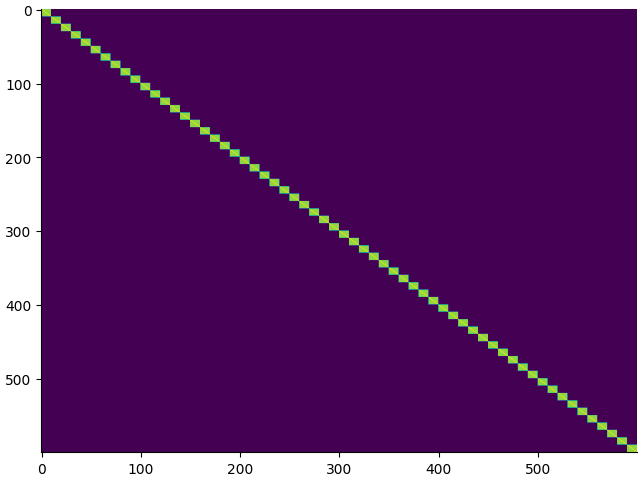

In [6]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 10
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [7]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [9]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.2, 0.6]) / 3
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
# c = 1
# JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
# sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)

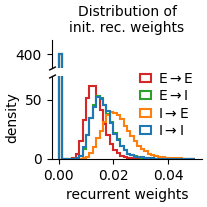

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(2, 2), height_ratios=[1, 3], constrained_layout=False)
fig.subplots_adjust(hspace=0.05)
if issparse(JEE):
    hist = [_.toarray().flatten() for _ in [JII, JEI, JIE, JEE]]
else:
    hist = [_.flatten() for _ in [JII, JEI, JIE, JEE]] 
for i in range(2):
    ax[i].hist(hist, bins=40, density=True, histtype='step', range=(0, 0.05), lw=1.5,
               label=[r'I$\to$I', r'I$\to$E', r'E$\to$I', r'E$\to$E'])
ax[0].set(ylim=[300, 500], yticks=[400], xticks=[])
ax[1].set(ylim=[0, 70], yticks=[0, 50], ylabel='density', xlabel='recurrent weights')
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0], [0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0], [1], transform=ax[1].transAxes, **kwargs)
ax[0].set_title('Distribution of\ninit. rec. weights', fontsize=10)
ax[1].legend(bbox_to_anchor=(0.5, 0.1), ncols=1, frameon=False,
             handlelength=0.8, handletextpad=0.5)
fig.tight_layout(pad=0.1)
fig.savefig('svg/J_dist.svg')

In [10]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [64]:
w0_mean = 1/N_HVC
w_inh, wI = w0_mean, 0.0
tauE, tauI, dt = 40, 10, 1

net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
            JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI, w0_std=1e-3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1675.57it/s]


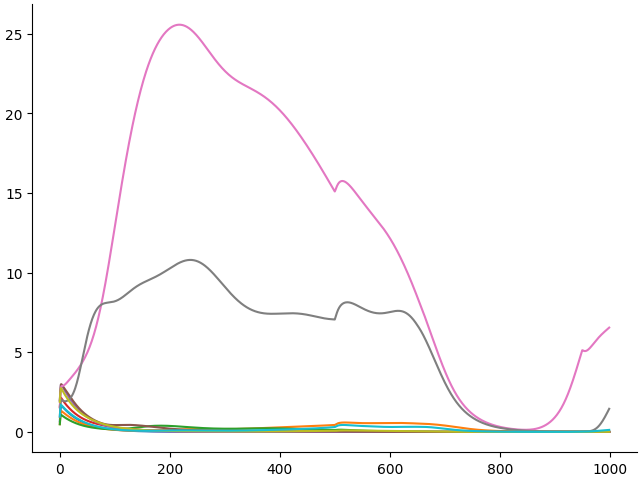

In [65]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = net.sim(rE0, rI0, *aux, [], 1000, dt, 0)
rE, rI, _, _, hE = _
plt.plot(rE[:1000,:10]);

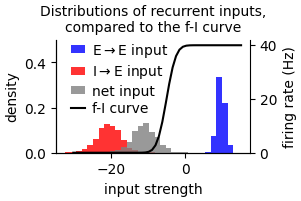

In [90]:
ee_in = (net.JEE @ rE[:500].T).T.mean(axis=0)
ei_in = (net.JEI @ rI[:500].T).T.mean(axis=0)
_ = np.linspace(-30, 15)
fig, ax = plt.subplots(1, figsize=(3, 2))
ax = [ax, ax.twinx()]
ax[1].spines.right.set_visible(True)
ax[0].hist([ee_in-ei_in, -ei_in, ee_in], bins=30, density=True, 
           histtype='stepfilled', alpha=0.8, color=['grey', 'r', 'b'],
           label=[r'net input', r'I$\to$E input', r'E$\to$E input'])
ax[0].plot(0, 0, c='k', label='f-I curve')
ax[0].legend(loc=(0.05, 0.28))
ax[1].plot(_, net.phiE(_), color='k', zorder=10)
ax[0].set(ylabel='density', xlabel='input strength', ylim=[0, 0.5])
ax[0].set_title('Distributions of recurrent inputs,\ncompared to the f-I curve', fontsize=10)
ax[1].set(ylim=[0, 42], ylabel='firing rate (Hz)')
fig.savefig('svg/show_EI_balance.svg', transparent=True)

In [13]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [14]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = net.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-8e-2, w0_mean=w0_mean, tauW=1e5)
rE, rI, Ws, mean_HVC_input, hE = _

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15499/15499 [00:07<00:00, 2201.79it/s]


(<Figure size 400x600 with 4 Axes>,
 array([<Axes: ylabel='$\\left\\langle \\| W \\|_F \\right\\rangle$'>,
        <Axes: ylabel='mean input\nfrom HVC'>,
        <Axes: ylabel='Mean exc. rate'>,
        <Axes: xlabel='Time (a.u.)', ylabel='Mean inh. rate'>],
       dtype=object))

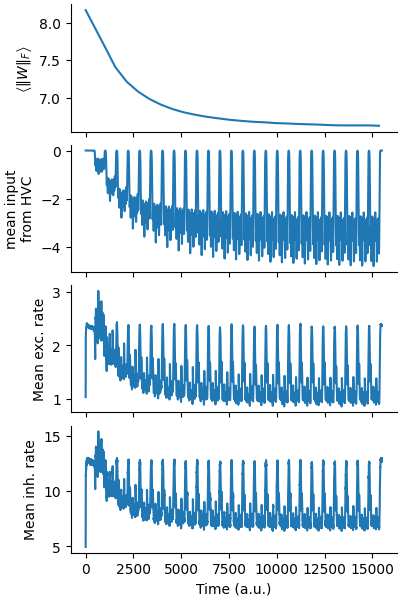

In [15]:
plot_train_stats(Ws, rE, mean_HVC_input, save_W_ts, rI)

In [16]:
W_syl_corrs = [correlation(_.T, syl, dim=2) for _ in Ws]

/home/zg93/Projects/Aiv-Network/src/visualization.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


(<Figure size 700x200 with 5 Axes>,
 array([<Axes: title={'center': 'Rendition 0'}, ylabel='HVC index'>,
        <Axes: title={'center': 'Rendition 8'}>,
        <Axes: title={'center': 'Rendition 17'}>,
        <Axes: title={'center': 'Rendition 25'}>], dtype=object))

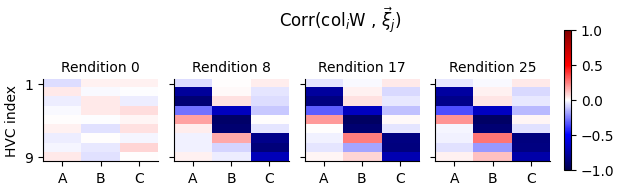

In [17]:
plot_wcol_corr(W_syl_corrs, (1, 4), (7, 2))

176


/tmp/ipykernel_30015/3262978825.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout(w_pad=0.2, h_pad=0.5)


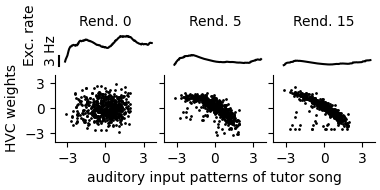

In [18]:
i = 0
rends = (0, 5, 15)
_ = [rE[int(tsyl_start[i,j]):int(tsyl_end[i,j])].mean(axis=0) for j in rends]
k = rng.choice(np.where((_[0]>_[1]+0.5)&(_[1]>_[2]+0.5))[0])
print(k)
fig, ax = plt.subplots(2, 3, figsize=(4, 2), sharey='row', sharex='row', 
                       height_ratios=[1, 2])
for c, j in enumerate(rends):
    ax[0,c].plot(rE[int(tsyl_start[i,j]):int(tsyl_end[i,j]),k], color='k')
    ax[0,c].set_title('Rend. %d' % j, fontsize=10)
    ax[1,c].plot(normalize(syl[i], 0), normalize(Ws[j][:,i*3+1], 0), '.', 
                 ms=2, color='k')
    ax[1,c].set(xlim=[-4, 4], ylim=[-4, 4], xticks=[-3, 0, 3])
    ax[0,c].set_axis_off()
ax[0,0].plot([-10, -10], [0, 3], c='k')
ax[0,0].text(-25, 0, '3 Hz', va='bottom', ha='center', rotation=90)
ax[0,0].text(-60, 0, 'Exc. rate', va='bottom', ha='center', rotation=90)
# ax[0,0].legend(loc=(0, 1), title='Rendition #', ncols=3, frameon=False, 
#            handlelength=1, columnspacing=1)
ax[1,0].set(yticks=[-3, 0, 3], ylabel='HVC weights')
ax[1,1].set_xlabel('auditory input patterns of tutor song')
fig.tight_layout(w_pad=0.2, h_pad=0.5)
fig.savefig('svg/training_res.svg')
# 2x3; label HVC inputs vs auditory inputs

/home/zg93/Projects/Aiv-Network/src/visualization.py:82: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


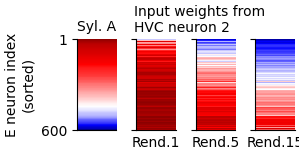

In [19]:
fig, ax = plot_example_colW_syl(Ws, syl[0], 1, [1, 5, 15])
# fig.savefig('weights.svg')

(<Figure size 400x450 with 3 Axes>,
 array([<Axes: ylabel='$\\left\\langle |\\Delta W_{ij}|\\right\\rangle_i$'>,
        <Axes: ylabel='weight corr.\nabs. change'>,
        <Axes: ylabel='$\\left\\langle |r^E - r^E_0| \\right\\rangle$'>],
       dtype=object))

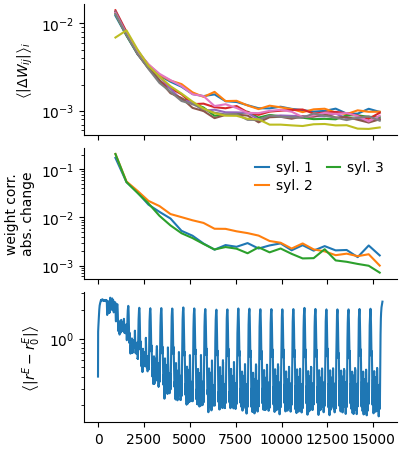

In [20]:
plot_train_converge(Ws, W_syl_corrs, save_W_ts, rE, 1)

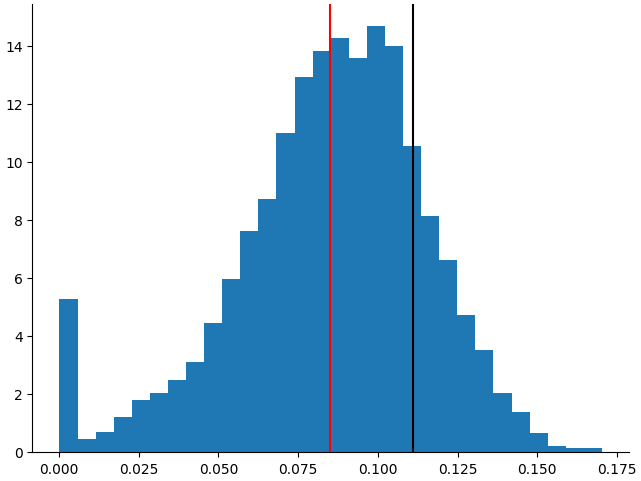

In [21]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')

## Test Model with Different Scenarios

In [22]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [23]:
exp = Experiment(net, rH, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert_args = [(pert_mean, pert_cov, 0)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/it]


In [24]:
rE_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['rE']]
syl_block_avgs = block_apply(syl, K=N_shared_channels, func=np.mean)
bos_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['bos']]

/home/zg93/Projects/Aiv-Network/src/visualization.py:143: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


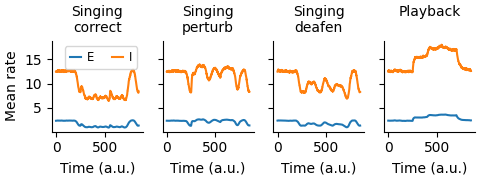

In [25]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all['rE'], tests_all['rI'], test_names, ti, tj)

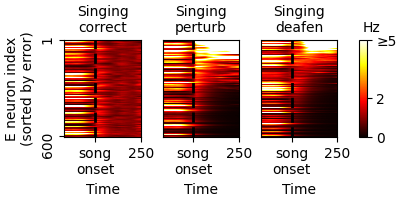

In [53]:
fig, ax = plot_raster_cmp_syl_dsyl(tests_all['rE'][:-1], test_names[:-1], syl[0], 
                                   [_[0]-syl[0] for _ in tests_all['bos']][:-1], 
                                   tsyl_start[0,0], tsyl_end[0,0], 
                                   figsize=(4, 2), plot_z=False, sort_by='e', th=5)
fig.savefig('svg/err_response_EI.svg', transparent=True)

In [ ]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(rE_block_avgs, bos_block_avgs, syl_block_avgs, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

In [ ]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(rE_block_avgs[:-1], bos_block_avgs[:-1], 
                                  syl_block_avgs, test_names[:-1],
                                  ti, tj, tid_perturb_input=(1, 2), 
                                  syl_order=so, y=1.3)
fig.savefig('svg/corr_EI.svg', transparent=True)

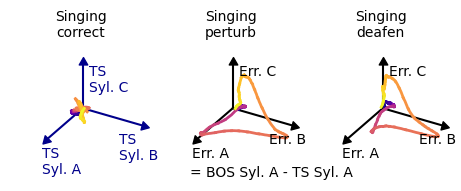

In [29]:
_ = bos_block_avgs[1] - syl_block_avgs
syl_norm = np.linalg.norm(syl_block_avgs, axis=1)
proj = [rE_block_avgs[0] @ syl_block_avgs.T / syl_norm**2,
         rE_block_avgs[1] @ _.T / np.linalg.norm(_, axis=1)**2,
         -rE_block_avgs[2] @ syl_block_avgs.T / syl_norm**2]
l1, l2 = 'TS\nSyl. %s', 'Err. %s'
dt = 10
cmap = plt.get_cmap('plasma')
fig, ax = plt.subplots(1, 3, figsize=(4.5, 2), subplot_kw={'projection':'3d'}, 
                       constrained_layout=True)
for i, (t, l) in enumerate(zip(test_names[:-1], (l1, l2, l2))):
    ax[i].view_init(elev=30, azim=30, roll=0)
    ax[i].set_box_aspect(aspect=None, zoom=1.5)
    c = 'k' if i > 0 else 'darkblue'
    ax[i].plot([0,1], [0,0], [0,0], c=c)
    ax[i].scatter(1, 0, 0, marker=(3,0,15), s=50, c=c)
    ax[i].text(1.1, 0, -0.05, l % 'A', ha='left', va='top', color=c)
    ax[i].plot([0,0], [0,1], [0,0], c=c)
    ax[i].scatter(0, 1, 0, marker=(3,0,15), s=50, c=c)
    ax[i].text(0, 0.6, -0.3, l % 'B', ha='left', va='top', color=c)
    ax[i].plot([0,0], [0,0], [0,1], c=c)
    ax[i].scatter(0, 0, 1, marker=(3,0,0), s=50, c=c)
    ax[i].text(0, 0.1, 1.0, l % 'C', ha='left', va='top', color=c)
    ax[i].grid(False)
    ax[i].set(xlim=[-1,1],ylim=[-1,1],zlim=[-1,1])
    ax[i].set_axis_off()
    ax[i].set_title(t, fontsize=10, va='top')
    for j in range(0, proj[i].shape[0]-1, dt):
        c = cmap(j/proj[i].shape[0])
        ax[i].plot(*(proj[i][j:j+dt+1].T), color=c, lw=2)
fig.text(0.41, 0.2, '= BOS Syl. A - TS Syl. A', ha='left', va='top')
fig.savefig('svg/traj_EI.svg', transparent=True)

449 151
84 66


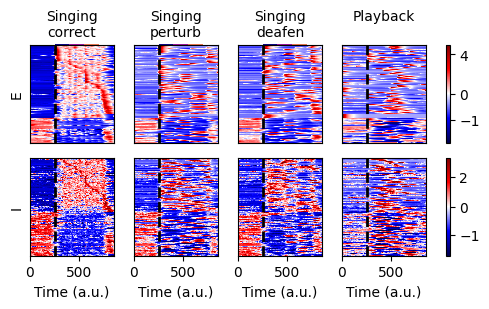

In [30]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all, test_names, 
                            ti, tj, T_burn, plot_inh=True, syl_order=so)

[(-1.0, 1.0)]

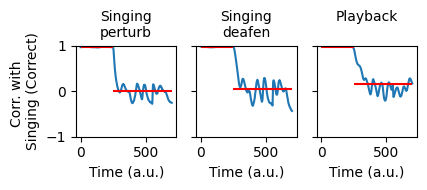

In [32]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all['rE'], test_names, ti, tj, T_burn)
# fig, ax = plot_corr_ctrl_nonctrl(rE_block_avgs, test_names, ti, tj, T_burn)
ax[0].set(ylim=[-1, 1])

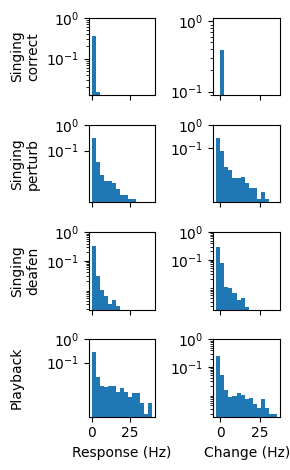

In [33]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all['rE'], test_names, tests_all['rE'][0], ti, tj)
# fig, ax = plot_rate_and_change_dists(rE_block_avgs, test_names, rE_block_avgs[0], ti, tj)